In [1]:
#!pip install bokeh

In [1]:

n_trajectories = 100


threshold1 = 0 # {10, 50, 100, 200, 300} default 200
threshold2 = 0.95 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold3 = 0.6 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold4 = 0 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5


In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance
import random
random.seed(123)
import pickle
from scipy import stats

import bokeh


# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

import max_ent.examples.grid_9_by_9 as G
from max_ent.utility.support import *
from max_ent.gridworld import Directions
from mc.mca import MCA
from mc.system1 import *
from max_ent.algorithms.gridworld_icrl import Demonstration

import pandas as pd

from bokeh.io import output_file, show
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource,
                          LinearColorMapper, PrintfTickFormatter)
from bokeh.plotting import figure
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import transform



np.random.seed(123)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [3]:
def compute_mean(target = None):

    df = pd.DataFrame()

    if target: 

        for i in range(0, len(target.time_stat)):
            #print(f"Stat: {mca.trajectory_stat[i]}")
            mask_1 = np.array(target.trajectory_stat[i]) == 1
            mask_2 = np.array(target.trajectory_stat[i]) == 0
            
            #Creaty np array from time array
            selected = np.array(target.time_stat[i])
            #Select actions in trajectory based on which system computed them
            selected_1= selected[mask_1]
            selected_2= selected[mask_2]
            #Compute total time per solver
            time_s1 = np.sum(selected_1)
            time_s2 = np.sum(selected_2)
            
            #Creaty np array from trajectory array
            selected = np.array(target.trajectory_stat[i])
            #Select builder in trajectory based on which system computed them
            selected_1= selected[mask_1]
            selected_2= selected[mask_2]
            #Compute total time per solver
            usage_s1 = np.sum(selected_1)
            usage_s2 = len(target.trajectory_stat[i]) - np.sum(selected_1)
            
            #Creaty np array from trajectory array
            selected = np.array(target.action_reward[i])
            #Select builder in trajectory based on which system computed them
            selected_1= selected[mask_1]
            selected_2= selected[mask_2]
            #Compute total time per solver
            reward_s1 = np.sum(selected_1)
            reward_s2 = np.sum(selected_2)
            
            selected = np.array(target.thresholds_stat[i])
            thresholds_stat_s1 = np.mean(selected[mask_1], axis=0)
            
            selected = np.array(target.thresholds_stat[i])
            thresholds_stat_s2 = np.mean(selected[mask_2], axis=0)
            

            dict_mca = {}
            dict_mca['traj_n'] = i
            dict_mca['length'] = len(target.trajectory_stat[i])
            dict_mca['reward'] = np.sum(target.action_reward[i])
            dict_mca['time'] = np.sum(target.time_stat[i])
            
            dict_mca['sub_type'] = "s1"
            dict_mca['time_agent'] = time_s1
            dict_mca['avg_time'] = time_s1 / usage_s1
            dict_mca['reward_agent'] = reward_s1
            dict_mca['avg_reward'] = reward_s1 / usage_s1
            dict_mca['usage']= usage_s1
            dict_mca['perc_usage']= usage_s1 / len(target.trajectory_stat[i])
            dict_mca['confidence'] = thresholds_stat_s1[2]
            temp_df = pd.DataFrame(data=dict_mca, index=[i])
            df = pd.concat([df, temp_df])
            
            
            dict_mca = {}
            dict_mca['traj_n'] = i
            dict_mca['length'] = len(target.trajectory_stat[i])
            dict_mca['reward'] = np.sum(target.action_reward[i])
            dict_mca['time'] = np.sum(target.time_stat[i])
            
            dict_mca['sub_type'] = "s2"
            dict_mca['time_agent'] = time_s2
            dict_mca['avg_time'] = time_s2 / usage_s2
            dict_mca['reward_agent'] = reward_s2
            dict_mca['avg_reward'] = reward_s2 / usage_s2
            dict_mca['usage']= usage_s2
            dict_mca['perc_usage']= usage_s2 / len(target.trajectory_stat[i])
            dict_mca['confidence'] = thresholds_stat_s2[2]
            
            temp_df = pd.DataFrame(data=dict_mca, index=[i])
            df = pd.concat([df, temp_df])
            
    else:
        dict_mca = {}
        dict_mca['traj_n'] = 0
        dict_mca['length'] = 0
        dict_mca['reward'] = 0
        dict_mca['time'] = 0

        dict_mca['sub_type'] = "null"
        dict_mca['time_agent'] = 0
        dict_mca['avg_time'] = 0 
        dict_mca['reward_agent'] = 0
        dict_mca['avg_reward'] = 0 
        dict_mca['usage']= 0
            
        temp_df = pd.DataFrame(data=dict_mca, index=[0])
        df = pd.concat([df, temp_df])

    
    #print(dict_mca)
    
    return df

In [4]:
## Set the grid
blue = [21,  9, 59,  1,  0, 20]
green = [42, 18, 76, 41, 23, 30]
cs = [63, 74, 13, 39, 48, 38]
ca = [Directions.DOWN_LEFT, Directions.UP_LEFT]
start =7
goal = 65

[0.962 0.062 0.062 0.962 0.962 0.062 0.962 0.963]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11030dc50>}


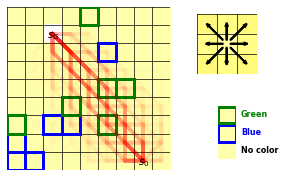

In [5]:
#blue, green, cs, ca, start, goal = generate_constraints(9)
n, n_cfg, demo_n, f1 = create_world('Nominal', blue, green, start=start, goal=goal)

[0.962 0.062 0.062 0.962 0.962 0.062 0.962 0.963]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11030dc50>}


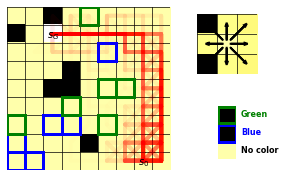

In [6]:
cc = [1, 2]
c, c_cfg, demo_c, f2 = create_world('Constrained', blue, green, cs, ca, cc, start=start, goal=goal, check=True)

In [7]:
'''from max_ent.algorithms.gridworld_icrl import Demonstration
demo_test = Demonstration([], demo_c.policy)

import pickle as pkl
import numpy as np

fileName = 'qvalues'
fileObject = open(fileName, 'wb')
pkl.dump(demo_c.policy, fileObject)
fileObject.close()

f1 = G.plot_world(f'MCA', c, c_cfg.state_penalties, 
              c_cfg.action_penalties, c_cfg.color_penalties, 
              demo_test, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)'''

"from max_ent.algorithms.gridworld_icrl import Demonstration\ndemo_test = Demonstration([], demo_c.policy)\n\nimport pickle as pkl\nimport numpy as np\n\nfileName = 'qvalues'\nfileObject = open(fileName, 'wb')\npkl.dump(demo_c.policy, fileObject)\nfileObject.close()\n\nf1 = G.plot_world(f'MCA', c, c_cfg.state_penalties, \n              c_cfg.action_penalties, c_cfg.color_penalties, \n              demo_test, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)"

IMMEDIATE 	 total_traj: 1.0
state_s 7 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.

IMMEDIATE 	 total_traj: 3.0
state_s 70 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 3.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  action_thresholds[1] = expected_avg_reward / current_reward
/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:299: RuntimeWarning: invalid value encountered in double_scalars
  x = np.abs(current_length - expected_avg_length) / max_diff_len


IMMEDIATE 	 total_traj: 3.0
state_s 34 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 3.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

IMMEDIATE 	 total_traj: 4.0
state_s 25 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 4.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

IMMEDIATE 	 total_traj: 2.0
state_s 17 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 2.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

IMMEDIATE 	 total_traj: 5.0
state_s 61 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 5.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

IMMEDIATE 	 total_traj: 3.0
state_s 7 	 action 1 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [3.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.

IMMEDIATE 	 total_traj: 12.0
state_s 69 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 12.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 10.0
state_s 61 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 9.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -

IMMEDIATE 	 total_traj: 17.0
state_s 66 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 14.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]]
IMMEDIATE 	 total_traj: 1.0
state_s 7 	 action 6 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657
 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657
 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657
 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657
 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657 -5.657
 -5.657 

IMMEDIATE 	 total_traj: 4.0
state_s 60 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 4.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

IMMEDIATE 	 total_traj: 22.0
state_s 68 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 21.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 5.0
state_s 60 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 5.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

IMMEDIATE 	 total_traj: 19.0
state_s 52 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 18.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 24.0
state_s 70 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 22.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

 -4.000]
temp_list: [[-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.333 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-3.667 -0.000 0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]]
IMMEDIATE 	 total_traj: 1.0
state_s 7 	 action 4 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 

IMMEDIATE 	 total_traj: 30.0
state_s 16 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 29.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 4.0
state_s 61 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 4.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

IMMEDIATE 	 total_traj: 8.0
state_s 60 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 8.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

IMMEDIATE 	 total_traj: 33.0
state_s 16 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 32.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 34.0
state_s 16 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 33.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 7.0
state_s 7 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [7.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.

IMMEDIATE 	 total_traj: 13.0
state_s 62 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 12.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 9.0
state_s 35 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 9.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 6.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000]
temp_list: [[-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -3.704 -0.074]
 [-0.000 -0.000 -0.0

IMMEDIATE 	 total_traj: 42.0
state_s 70 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 2.000 39.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 10.0
state_s 35 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 10.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 51.0
state_s 16 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 2.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 48.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 51.0
state_s 70 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 2.000 46.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 2.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 13.0
state_s 8 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [2.000 10.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -

IMMEDIATE 	 total_traj: 8.0
state_s 7 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [8.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.

IMMEDIATE 	 total_traj: 62.0
state_s 16 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 2.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 59.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 56.0
state_s 52 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 53.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 11.0
state_s 61 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 11.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 63.0
state_s 70 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 2.000 58.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 2.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 4.0
state_s 56 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 3.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

 [2.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 6.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000]
temp_list: [[-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000]
 [-0.000 -0.000 -0.0

IMMEDIATE 	 total_traj: 12.0
state_s 61 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 12.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 72.0
state_s 16 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 2.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 69.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 64.0
state_s 52 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 61.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

state_s 43 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 66.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 1.000 0.000 2.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -

IMMEDIATE 	 total_traj: 92.0
state_s 66 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 4.000 82.000 1.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 2.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 94.0
state_s 66 	 action 0 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 4.000 83.000 1.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 2.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000 1.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 2.0
state_s 40 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 2.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4

IMMEDIATE 	 total_traj: 19.0
state_s 17 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 18.000 0.000 0.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

IMMEDIATE 	 total_traj: 85.0
state_s 34 	 action 2 	 [[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 1.000 1.000 2.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 2.000 0.000 77.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 1.000 0.000 0.000 0.000 0.000]]
prob [-4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000 -4.000
 

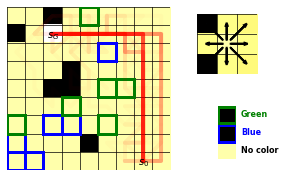

In [8]:
s1 = System1Solver(myopic=True)
mca = MCA(n=n, c=c, s1=s1, demo=None, threshold1 = threshold1, threshold2 = threshold2, threshold3 = threshold3, threshold4 = threshold4, threshold5 = 1)
demo_mca = mca.generate_trajectories(n_trajectories)

#mca = MCA(s1,s2,modelSelf, threshold1=threshold1, threshold2=threshold2, threshold3 = threshold3, threshold5 = threshold5, threshold7 = threshold7)
#print(c)
f1 = G.plot_world(f'MCA', c, c_cfg.state_penalties, 
              c_cfg.action_penalties, c_cfg.color_penalties, 
              demo_mca, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)


In [9]:
mca.__dict__['thresholds_stat']

[[array([0.000, 0.000, 0.001, -inf, -4.000, 0.003, 0.052]),
  array([0.000, -inf, 0.001, -inf, -4.000, 0.124, 0.087]),
  array([0.000, -inf, 0.001, -inf, -4.000, 0.105, 0.407]),
  array([0.000, -inf, 0.001, -inf, -4.000, 0.101, 0.108]),
  array([0.000, -inf, 0.001, -inf, -4.000, 0.100, 0.901]),
  array([0.000, -inf, 0.001, -inf, -4.000, 0.103, 0.038]),
  array([0.000, -inf, 0.001, -inf, -4.000, 0.108, 0.536]),
  array([0.000, -inf, 0.001, -inf, -4.000, 0.117, 0.332]),
  array([0.000, -inf, 0.001, -inf, -4.000, 0.128, 0.852]),
  array([0.000, -inf, 0.001, -inf, -4.000, 0.141, 0.160]),
  array([0.000, -inf, 0.001, -inf, -4.000, 0.159, 0.337]),
  array([0.000, -inf, 0.001, -inf, -4.000, 0.182, 0.334])],
 [array([1.000, 0.000, 0.906, -38.000, -38.000, 0.061, 0.245]),
  array([1.000, 1.000, 0.819, 0.000, 0.000, 0.000, 0.000]),
  array([1.000, 1.000, 0.906, 0.000, 0.000, 0.000, 0.000]),
  array([1.000, 1.000, 0.906, 0.000, 0.000, 0.000, 0.000]),
  array([1.000, 1.000, 0.906, 0.000, 0.000, 0.

In [35]:
print(mca.__dict__.keys())

mca.__dict__['action_reward']

average_stat = compute_mean(mca)
#np.mean(mca.thresholds_stat[0], axis=0)[2]
#mca.modelSelf.ntra_per_transition[(0,0)][1]*mca.modelSelf.grid.reward[0][1].reshape((9,9))

#np.sum(mca.modelSelf.ntra_per_transition[(0,0)][1])
print(mca.modelSelf.__dict__.keys())
mca.__dict__["max_time_s2"]

dict_keys(['s1', 's2', 'modelSelf', 'threshold1', 'threshold2', 'threshold3', 'threshold4', 'threshold5', 'threshold6', 'threshold7', 'usage_s1', 'usage_s2', 'time_usage_s2', 'w', 'trajectory_stat', 'thresholds_stat', 'thresholds_mask', 'time_stat', 'violations', 'action_reward', 'fixed_time_left', 'time_left', 'only_s1', 'only_s2', 'max_time_s2', 'mixed'])


/Users/aloreggia/Documents/GitHub/wmca/max_ent/utility/support.py:72: RuntimeWarning: invalid value encountered in long_scalars
  dict_mca['avg_time'] = time_s1 / usage_s1
/Users/aloreggia/Documents/GitHub/wmca/max_ent/utility/support.py:74: RuntimeWarning: invalid value encountered in double_scalars
  dict_mca['avg_reward'] = reward_s1 / usage_s1
/Users/aloreggia/Documents/GitHub/wmca/max_ent/utility/support.py:89: RuntimeWarning: invalid value encountered in long_scalars
  dict_mca['avg_time'] = time_s2 / usage_s2
/Users/aloreggia/Documents/GitHub/wmca/max_ent/utility/support.py:91: RuntimeWarning: invalid value encountered in double_scalars
  dict_mca['avg_reward'] = reward_s2 / usage_s2


dict_keys(['ntra_per_transition', 'ntra_per_transition_s2', 'ntra_per_stateAction', 'ntra_per_stateAction_s2', 'ntra_per_state', 'ntra_per_state_s2', 'part_length', 'part_reward', 'part_reward_s2', 'part_reward_state_action', 'prob', 'prob_remaining', 'prob_s2', 'n', 'std', 'grid', 'constraints', 'avg_reward', 'total_transitions', 's1_wrong'])


124

In [36]:
average_stat#.loc[average_stat['sub_type']=='s1'].length[0]
average_stat.loc[average_stat['sub_type']=='s2'].reward_agent[0]
average_stat.loc[average_stat['sub_type']=='s1'].reward_agent[0]
average_stat.reward

mask_1 = np.array(mca.trajectory_stat[5]) == 1
selected = np.array(mca.thresholds_stat[5])

np.mean(mca.thresholds_stat[5], axis=0)
average_stat

traj_n  length      reward  time sub_type  time_agent   avg_time  \
0         0      14  -47.656854   281       s1           0        NaN   
0         0      14  -47.656854   281       s2         281  20.071429   
1         1      12  -38.000000    20       s1           2   0.181818   
1         1      12  -38.000000    20       s2          18  18.000000   
2         2      14  -46.000000    69       s1           1   0.100000   
..      ...     ...         ...   ...      ...         ...        ...   
497     497      14  -46.000000    35       s2          33  16.500000   
498     498      18 -112.000000   130       s1           0   0.000000   
498     498      18 -112.000000   130       s2         130  16.250000   
499     499      13 -188.000000   134       s1           1   0.200000   
499     499      13 -188.000000   134       s2         133  16.625000   

     reward_agent  avg_reward  usage  perc_usage  
0        0.000000         NaN      0    0.000000  
0      -47.656854   -3.404061     14    1.000000  
1      -34.000000   -3.090909     11    0.916667  
1       -4.000000   -4.000000      1    0.083333  
2      -40.000000   -4.000000     10    0.714286  
..            ...         ...    ...         ...  
497     -8.000000   -4.000000      2    0.142857  
498    -90.000000   -9.000000     10    0.555556  
498    -22.000000   -2.750000      8    0.444444  
499    -70.000000  -14.000000      5    0.384615  
499   -118.000000  -14.750000      8    0.615385  

[1000 rows x 11 columns]

In [37]:
#np.mean(selected[mask_1], axis=0)

mca.thresholds_stat[11][mask_1]

In [38]:
from bokeh.plotting import figure, show

x_traj = [x for x in range(n_trajectories)]
y_action = mca.__dict__['action_reward']
y_time = mca.__dict__['time_stat']

y_mean_action = [np.mean(m) for m in y_action]
y_mean_time = [np.mean(m) for m in y_time]
#print(y_time)

In [39]:
max_x = np.max([len(t) for t in y_action])
min_y_action = np.min([min(t) for t in y_action]) - 5
max_y_action = np.max([max(t) for t in y_action]) + 5

min_y_time = np.min([min(t) for t in y_time]) - 5
max_y_time = np.max([max(t) for t in y_time]) + 5

min_y_reward = np.min(average_stat.reward)

In [40]:
#mca.thresholds_stat[5]

In [41]:
df_confidence = dict(y = [np.mean(mca.thresholds_stat[xi], axis=0)[2] for xi in range(n_trajectories)])
#df_confidence

In [42]:
'''max_len = max(map(len, mca.__dict__['trajectory_stat']))
array = np.ones((len(mca.thresholds_mask), max_len)) *2

data'''

"max_len = max(map(len, mca.__dict__['trajectory_stat']))\narray = np.ones((len(mca.thresholds_mask), max_len)) *2\n\ndata"

In [43]:
index_stat=150
data = pd.DataFrame()
max_len = max(map(len, mca.__dict__['trajectory_stat']))
for traj in range(len(mca.thresholds_mask)):
    for i in range(len(mca.thresholds_mask[traj])):
        for t in range(7):
            temp = {}
            temp['transition'] = i
            temp['traj'] = traj
            if t==0:
                temp['threshold'] = str("#Traj")
            elif t==1:
                temp['threshold'] = str("Reward")
            elif t==2:
                temp['threshold'] = str("Conf.")
            elif t==3:
                temp['threshold'] = str("S1-S2")
            elif t==4:
                temp['threshold'] = str("Cost")
            elif t==5:
                temp['threshold'] = str("Chance")
            else: 
                temp['threshold'] = str("EngageS2")
                
           # if i< len(mca.thresholds_mask[traj]):
            temp['value'] = mca.thresholds_mask[traj][i][t]
            #else:
            #    temp['value'] = 2
                
            #print( pd.DataFrame(temp, index=[0]))
            data = pd.concat([data, pd.DataFrame(temp, index=[0])], ignore_index=True)

data.traj = data.traj.astype(str)
data.transition = data.transition.astype(str)
data = data.set_index('traj')


In [44]:
data.iloc[data.index=='0']

transition threshold  value
traj                            
0             0     #Traj    1.0
0             0    Reward    1.0
0             0     Conf.    1.0
0             0     S1-S2    0.0
0             0      Cost    1.0
...         ...       ...    ...
0            13     Conf.    1.0
0            13     S1-S2    0.0
0            13      Cost    1.0
0            13    Chance    1.0
0            13  EngageS2    1.0

[98 rows x 3 columns]

In [45]:
print(bokeh.__version__)
from bokeh.models import Div, CustomJS, Slider, RadioGroup
from bokeh.layouts import layout, gridplot, row
from bokeh.plotting import ColumnDataSource, output_file

df_action = dict(x = [xi for xi in range(max_x)], y=y_action[0])
df_time = dict(x = [xi for xi in range(max_x)], y=y_time[0])
#df_confidence = dict(x = [np.mean(mca.thresholds_stat[xi], axis=0)[2] for xi in range(n_trajectories)], y=y_time[0])
df_length = dict(x=[0], top=[average_stat.loc[average_stat['sub_type']=='s2'].length[0]])

systems_type = ["S1", "S2"]
colors_bar = ["blue", "orange"]

df_reward = dict(x=[0], S2=[average_stat.loc[average_stat['sub_type']=='s2'].reward_agent[0]], S1=[average_stat.loc[average_stat['sub_type']=='s1'].reward_agent[0]])
df_time_agent = dict(x=[0], S2=[average_stat.loc[average_stat['sub_type']=='s2'].time_agent[0]], S1=[average_stat.loc[average_stat['sub_type']=='s1'].time_agent[0]])


source = ColumnDataSource(data=df_action)
source_time = ColumnDataSource(data=df_time)
source_length = ColumnDataSource(data=df_length)
source_reward = ColumnDataSource(data=df_reward)
source_time_agent = ColumnDataSource(data=df_time_agent)


avg_plot = figure(title="Avg. action reward per trajectory", x_range=(0,n_trajectories), width=400, height=250)
avg_plot.circle(x_traj, average_stat.loc[average_stat['sub_type']=='s1'].avg_reward, color='orange', fill_alpha=0.6, line_width=2, line_alpha=0.6, legend_label="S1")
avg_plot.circle(x_traj, average_stat.loc[average_stat['sub_type']=='s2'].avg_reward, color='blue', fill_alpha=0.6, line_width=2, line_alpha=0.6, legend_label="S2")

avg_plot_time = figure(title="Avg. action time per trajectory",x_range=(0,n_trajectories), width=400, height=250)
avg_plot_time.circle(x_traj, average_stat.loc[average_stat['sub_type']=='s1'].avg_time, color='orange', fill_alpha=0.6, line_width=2, line_alpha=0.6, legend_label="S1")
avg_plot_time.circle(x_traj, average_stat.loc[average_stat['sub_type']=='s2'].avg_time, color='blue', fill_alpha=0.6, line_width=2, line_alpha=0.6, legend_label="S2")

avg_plot_usage = figure(title="Frac. use times per trajectory",x_range=(0,n_trajectories), width=400, height=250)
avg_plot_usage.circle(x_traj, average_stat.loc[average_stat['sub_type']=='s1'].perc_usage, color='orange', fill_alpha=0.6, line_width=2, line_alpha=0.6, legend_label="S1")
avg_plot_usage.circle(x_traj, average_stat.loc[average_stat['sub_type']=='s2'].perc_usage, color='blue', fill_alpha=0.6, line_width=2, line_alpha=0.6, legend_label="S2")

avg_plot_confidence = figure(title="Avg confidence per trajectory",x_range=(0,n_trajectories), width=400, height=250)
avg_plot_confidence.circle(x_traj, df_confidence['y'], color='orange', fill_alpha=0.6, line_width=2, line_alpha=0.6, legend_label="S1")
#avg_plot_confidence.circle(x_traj, average_stat.loc[average_stat['sub_type']=='s2'].perc_usage, color='blue', fill_alpha=0.6, line_width=2, line_alpha=0.6, legend_label="S2")

##########################################

df = pd.DataFrame(data.iloc[data.index=='0'])
df_all = pd.DataFrame(data)
#print(df)
source_threshold_mask = ColumnDataSource(df)
source_all = ColumnDataSource(df_all)

# this is the colormap from the original NYTimes plot
colors = ["#ff0000", "#00ff00"]
mapper = LinearColorMapper(palette=colors, low=0, high=1)

p_threshold_mask = figure(width=400, height=250, \
           x_range=list(pd.unique(data.iloc[data.index=='0'].transition)), \
            y_range=list(reversed(pd.unique(data.iloc[data.index=='0']['threshold'].values))), toolbar_location=None, tools="", x_axis_location="above")

p_threshold_mask.rect(x="transition", y="threshold", width=1, height=1, source=source_threshold_mask, line_color="white", fill_color=transform('value', mapper))

color_bar = ColorBar(color_mapper=mapper,
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%d%%"))

#p_threshold_mask.add_layout(color_bar, 'right')

p_threshold_mask.axis.axis_line_color = None
p_threshold_mask.axis.major_tick_line_color = None
p_threshold_mask.axis.major_label_text_font_size = "7px"
p_threshold_mask.axis.major_label_standoff = 0
p_threshold_mask.xaxis.major_label_orientation = 1.0

###########################################


p = figure(x_range=(0,max_x), y_range=(min_y_action,max_y_action),width=400, height=250, title="Reward per action")
p.line('x', 'y', source=source, line_width=3, line_alpha=0.6)
slider = Slider(start=0, end=n_trajectories, value=0, step=1, title="Select a trajectory")
callback = CustomJS(args=dict(source=source, 
                              source_time=source_time, 
                              source_length=source_length, 
                              #source_reward=source_reward,
                              #source_time_agent=source_time_agent, 
                              source_threshold_mask=source_threshold_mask, 
                              fig_range = p_threshold_mask.x_range,
                              new_data_thresholds_mask=mca.thresholds_mask, 
                              slider=slider, 
                              new_data=y_action, 
                              new_data_time=y_time, 
                              df_length = average_stat.loc[average_stat['sub_type']=='s2'].length,  
                              df_reward_s2 = average_stat.loc[average_stat['sub_type']=='s2'].reward_agent ,  
                              df_reward_s1 = average_stat.loc[average_stat['sub_type']=='s1'].reward_agent,
                              df_time_s2 = average_stat.loc[average_stat['sub_type']=='s2'].time_agent ,  
                              df_time_s1 = average_stat.loc[average_stat['sub_type']=='s1'].time_agent),
                    code="""
    const data = source.data;
    const data_time = source_time.data;
    const data_length = source_length.data;
    //const data_reward = source_reward.data;
    //const data_time_agent = source_time_agent.data;
    
    const x = data['x']
    const y = data['y']
    const y_time = data_time['y']
    const y_length = data_length['top']
    
    //const y_reward_s1 = data_reward['S1']
    //const y_reward_s2 = data_reward['S2']
    
    //const y_time_s1 = data_time_agent['S1']
    //const y_time_s2 = data_time_agent['S2']

    for (let i = 0; i < x.length; i++) {
        y[i] = new_data[slider.value][i]
        y_time[i] = new_data_time[slider.value][i]
    }
    y_length[0] = df_length[slider.value] 
    
    console.log('data_reward: ' + df_reward_s1[slider.value])
    
    //y_reward_s1[0] = df_reward_s1[slider.value] 
    //y_reward_s2[0] = df_reward_s2[slider.value] 
    
    //y_time_s1[0] = df_time_s1[slider.value] 
    //y_time_s2[0] = df_time_s2[slider.value] 
    
    const data_thresholds_mask = source_threshold_mask.data;
    var x_thresholds_mask = data_thresholds_mask['transition']
    var y_thresholds_mask = data_thresholds_mask['threshold']
    var value_rect = data_thresholds_mask['value']
    
    console.log('old_value: ' + value_rect)
    
    console.log('x: ' + x_thresholds_mask)    
    console.log('y: ' + y_thresholds_mask)

    
    fig_range.start = 0
    fig_range.end = new_data_thresholds_mask[slider.value].length
    var arr = {0:'#Traj', 1:'Reward', 2:'Conf.', 3:'t3', 4:'Use S2', 5:'#Traj S2', 6:'Chance'}
    
    for (let i = 0; i < new_data_thresholds_mask[slider.value].length; i++) {
         //data['value'][i]=new_data_thresholds_mask[slider.value][i][j]
         for (let j = 0; j < new_data_thresholds_mask[slider.value][i].length; j++) {
             data_thresholds_mask['value'][i*7 + j]=new_data_thresholds_mask[slider.value][i][j]
             //data_thresholds_mask['x'][i*7 + j]= i
             //data_thresholds_mask['y'][i*7 + j]= arr[j]
             console.log('new data i,3: ' + new_data_thresholds_mask[slider.value][i][j])   
         }
    }
    
    source_threshold_mask.change.emit()
    source.change.emit();
    source_time.change.emit();
    source_length.change.emit();
    //source_reward.change.emit();
    //source_time_agent.change.emit();
""")

slider.js_on_change('value', callback)

p_time = figure(x_range=(0,max_x), y_range=(min_y_time,max_y_time),width=400, height=250, title="Time per action")
p_time.line('x', 'y', source=source_time, line_width=3, line_alpha=0.6)

'''tot_reward = figure(height=250, width=150, title="Total Reward", toolbar_location=None, tools="", y_range=(min_y_reward,0))
tot_reward.vbar_stack(systems_type, width=0.9, legend_label=systems_type, color=colors_bar, source=source_reward)
tot_reward.xgrid.grid_line_color = None

tot_time = figure(height=250, width=150, title="Total Time", toolbar_location=None, tools="", y_range=(0,max_y_time))
tot_time.vbar_stack(systems_type, width=0.9, legend_label=systems_type, color=colors_bar, source=source_time_agent)
tot_time.xgrid.grid_line_color = None

tot_length = figure(height=250, width=150, title="Total Length", toolbar_location=None, tools="", y_range=(0,max_x))
tot_length.vbar(source=source_length, width=0.9)
tot_length.xgrid.grid_line_color = None
tot_length.y_range.start = 0'''


#l = layout([[p, [p_time, tot_length]], slider, [avg_plot, avg_plot_time]])
#l = layout([[p, p_time], slider, [avg_plot, avg_plot_time]])
#row1 = row(p, tot_reward, p_time, tot_time, tot_length)
row1 = row(p_threshold_mask)
#row3 = row(avg_plot, avg_plot_usage, avg_plot_confidence)
row3 = row(avg_plot, avg_plot_usage, avg_plot_time)
l2 = layout([row1, slider, row3 ])

output_file("results__expXconf_noMyopic_risk06.html")

show(l2)

#show(p)

2.4.2


In [22]:
print("Ntraj \t cRew/avgRew \t conf \t rewS1 \t rewS2 \t costS2")
np.set_printoptions(formatter={'float': lambda x: "{:4.3f}".format(x)})
i = 0
print(mca.__dict__['trajectory_stat'][i])
len(mca.__dict__['thresholds_mask'][i])

Ntraj 	 cRew/avgRew 	 conf 	 rewS1 	 rewS2 	 costS2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


55

In [23]:
from bokeh.models import Div, CustomJS, Slider, RadioGroup
from bokeh.layouts import layout, gridplot, row
from bokeh.plotting import ColumnDataSource, output_file

df = pd.DataFrame(data.iloc[data.index=='0'])
df_all = pd.DataFrame(data)
#print(df)
source_threshold_mask = ColumnDataSource(df)
source_all = ColumnDataSource(df_all)

# this is the colormap from the original NYTimes plot
colors = ["#000000", "#00ff00","#aaaaaa", "#0000ff"]
mapper = LinearColorMapper(palette=colors, low=0, high=1)

p_threshold_mask = figure(width=400, height=250, \
           x_range=list(pd.unique(data.iloc[data.index=='0'].transition)), \
            y_range=list(reversed(pd.unique(data.iloc[data.index=='0']['threshold'].values))), toolbar_location=None, tools="", x_axis_location="above")

p_threshold_mask.rect(x="transition", y="threshold", width=1, height=1, source=source_threshold_mask, line_color="white", fill_color=transform('value', mapper))

color_bar = ColorBar(color_mapper=mapper,
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%d%%"))

p_threshold_mask.add_layout(color_bar, 'right')

p_threshold_mask.axis.axis_line_color = None
p_threshold_mask.axis.major_tick_line_color = None
p_threshold_mask.axis.major_label_text_font_size = "7px"
p_threshold_mask.axis.major_label_standoff = 0
p_threshold_mask.xaxis.major_label_orientation = 1.0


slider = Slider(start=0, end=n_trajectories, value=0, step=1, title="Select a trajectory")

callback = CustomJS(args=dict(source=source_threshold_mask, 
                              slider=slider, 
                              fig_range = p_threshold_mask.x_range,
                              new_data=mca.thresholds_mask, 
                              ),
                    code="""
    const data = source.data;
    console.log('length: ' + new_data[slider.value].length)    
    console.log('new data 0: ' + new_data[0])   
        
    var x = data['transition']
    var y = data['threshold']
    var value_rect = data['value']
    
    console.log('old_value: ' + value_rect)
    
    console.log('x: ' + x)    
    console.log('y: ' + y)

    
    fig_range.start = 0
    fig_range.end = new_data[slider.value].length
    
    
    for (let i = 0; i < new_data[slider.value].length; i++) {
         //data['value'][i]=new_data[slider.value][i][j]
         for (let j = 0; j < new_data[slider.value][i].length; j++) {
             data['value'][i*7 + j]=new_data[slider.value][i][j]
             console.log('new data i,3: ' + new_data[slider.value][i][j])   
         }
    }
    
    
    
    source.change.emit();
""")

'''def callback(attr, old, new):
    N = slider.value
    df = pd.DataFrame(data.iloc[data.index==str(N)])
    source = ColumnDataSource(df)'''


slider.js_on_change('value', callback)
#slider.on_change('value', callback)

l = layout([p_threshold_mask, slider])

output_file("results_mask.html")


show(l)

In [59]:
mca.__dict__['thresholds_stat'][1]

[array([  1.        ,   0.        ,   0.90585293, -47.65685425,
        -47.65685425,   0.06690476,   0.08909768]),
 array([1.        , 1.        , 0.81896425, 0.        , 0.        ,
        0.        , 0.        ]),
 array([1.        , 1.        , 0.90585293, 0.        , 0.        ,
        0.        , 0.        ]),
 array([1.        , 2.80473785, 0.96165409, 0.        , 0.        ,
        0.        , 0.        ]),
 array([1.        , 1.60355339, 0.90585293, 0.        , 0.        ,
        0.        , 0.        ]),
 array([1.        , 1.48284271, 0.90585293, 0.        , 0.        ,
        0.        , 0.        ]),
 array([1.        , 1.40236893, 0.90585293, 0.        , 0.        ,
        0.        , 0.        ]),
 array([1.        , 1.34488765, 0.90585293, 0.        , 0.        ,
        0.        , 0.        ]),
 array([1.        , 1.3017767 , 0.90585293, 0.        , 0.        ,
        0.        , 0.        ]),
 array([1.        , 1.26824595, 0.90585293, 0.        , 0.        ,
